# REGex Project-1
# Team 5
## Team Members:
## 1. Avinash K
## 2. Raj Sankar GS
## 3. Misba Khatija
## 4. Manasvi Garg

# INTRODUCTION
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores.


##### Data Description
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# APRROACH
- Data Exploration: load and check missing value,
- Data Visualization: EDA
- Data Manipulation: change data types, impute data, create new features,
- Data Modeling: multiple traditional ML algorithms regressions


# LIBRARY

In [11]:
# Data Processing
import numpy as np
import pandas as pd
from pandas import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec
from IPython.display import display
%matplotlib inline


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm

# Data Evaluation
from sklearn.metrics import mean_squared_error

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF

# Warning ignore
import warnings
warnings.filterwarnings("ignore")

# DATA EXPLORATION

In [12]:
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")
test = pd.read_csv("test.csv", parse_dates = True, index_col = 'Date')

In [13]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [14]:
# Change datatype of InvoiceDate as datetime type
train['Date'] = pd.to_datetime(train['Date'])

In [15]:
# data extraction
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

In [16]:
# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

#### Observation:
On average customers spend about 9.50$ per day.

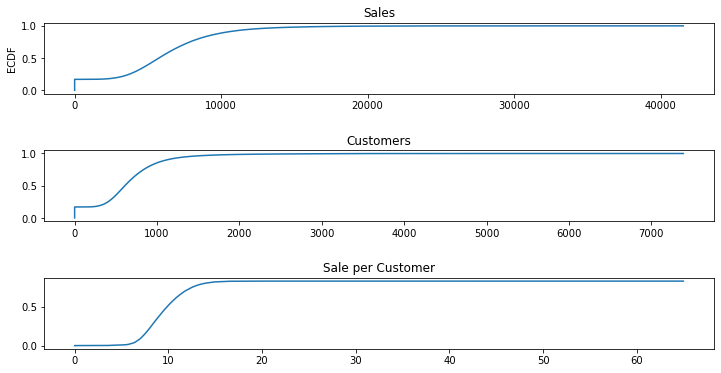

In [18]:
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sale per Customer');
plt.subplots_adjust(hspace = 0.8)

#### Observation:
About 20% of data has zero amount of sales/customers probably due to the fact that the store is closed for state holidays or school holidays

<AxesSubplot:xlabel='Sales', ylabel='Density'>

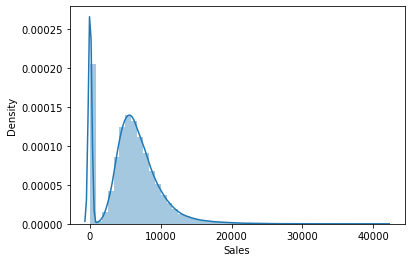

In [19]:
sns.distplot(train['Sales'])

In [20]:
# Closed Stores with zero sales
train[(train.Open == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
291,292,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
875,876,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
1406,292,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
1990,876,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
2521,292,3,2015-07-29,0,0,0,1,0,1,2015,7,29,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN


In [21]:
# Opened stores with zero sales
len(train[(train.Open == 1) & (train.Sales == 0)])

54

#### Observation:
- 172817 closed stores with 0 sales.
- 52 store opened but without sales.
- We just keep opened stores with sales for analysis.

In [22]:
# Closed stores and days which didn't have any sales won't be counted into the forecasts.
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


### Filling Missing Values

In [23]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [24]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [25]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [26]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [27]:
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

test_store = pd.merge(test, store, how = 'inner', on = 'Store')

train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store Type

In [28]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [29]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


#### Observation:
- StoreType B has the highest average of Sales among all others, however we have much less data for it
- Clearly, StoreType A come as first, StoreType D goes on the second place in both Sale and Customers

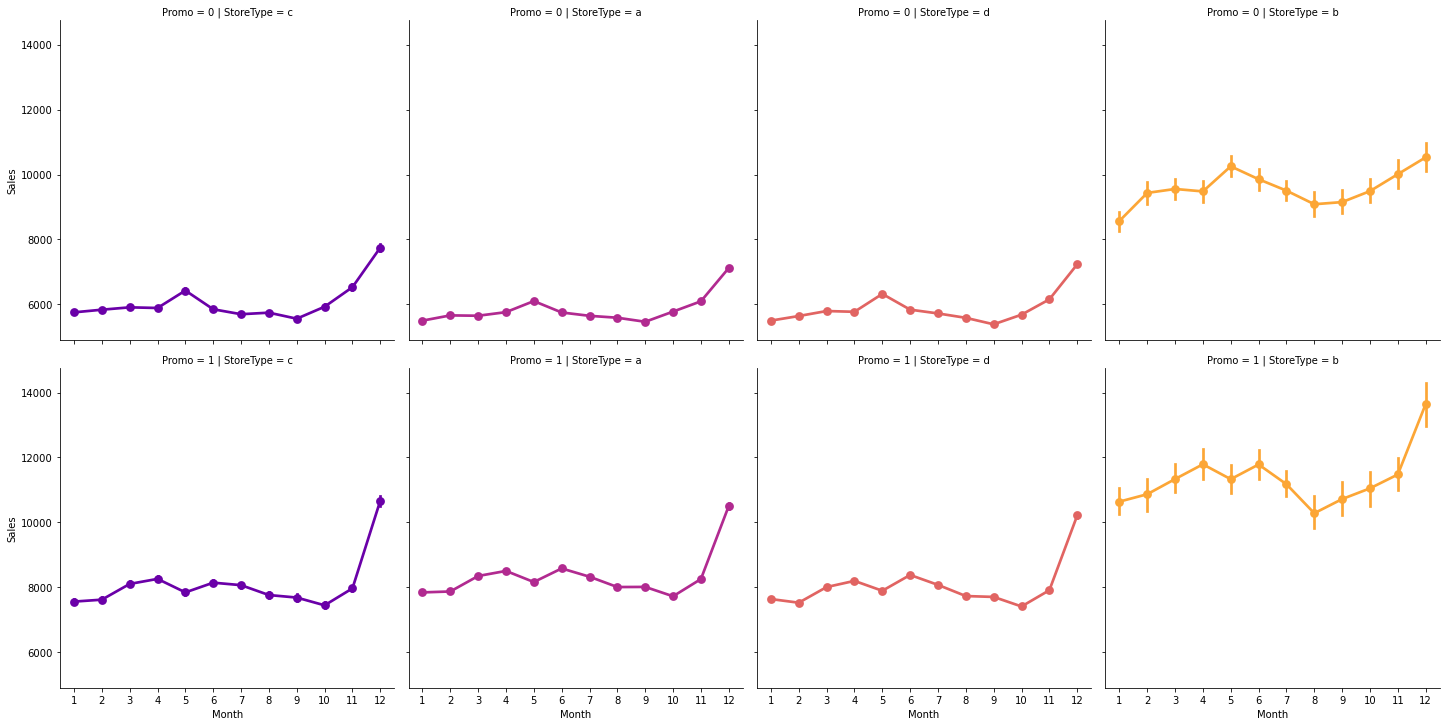

In [30]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

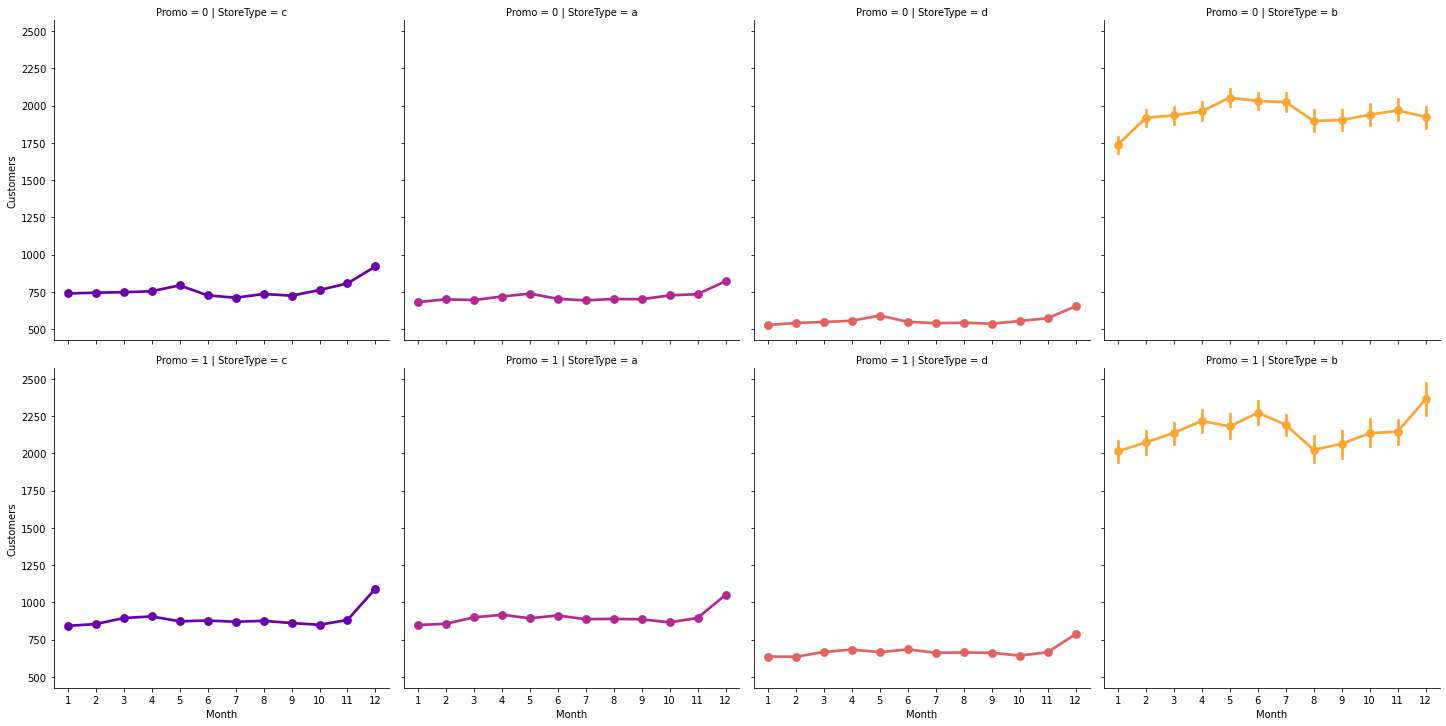

In [31]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

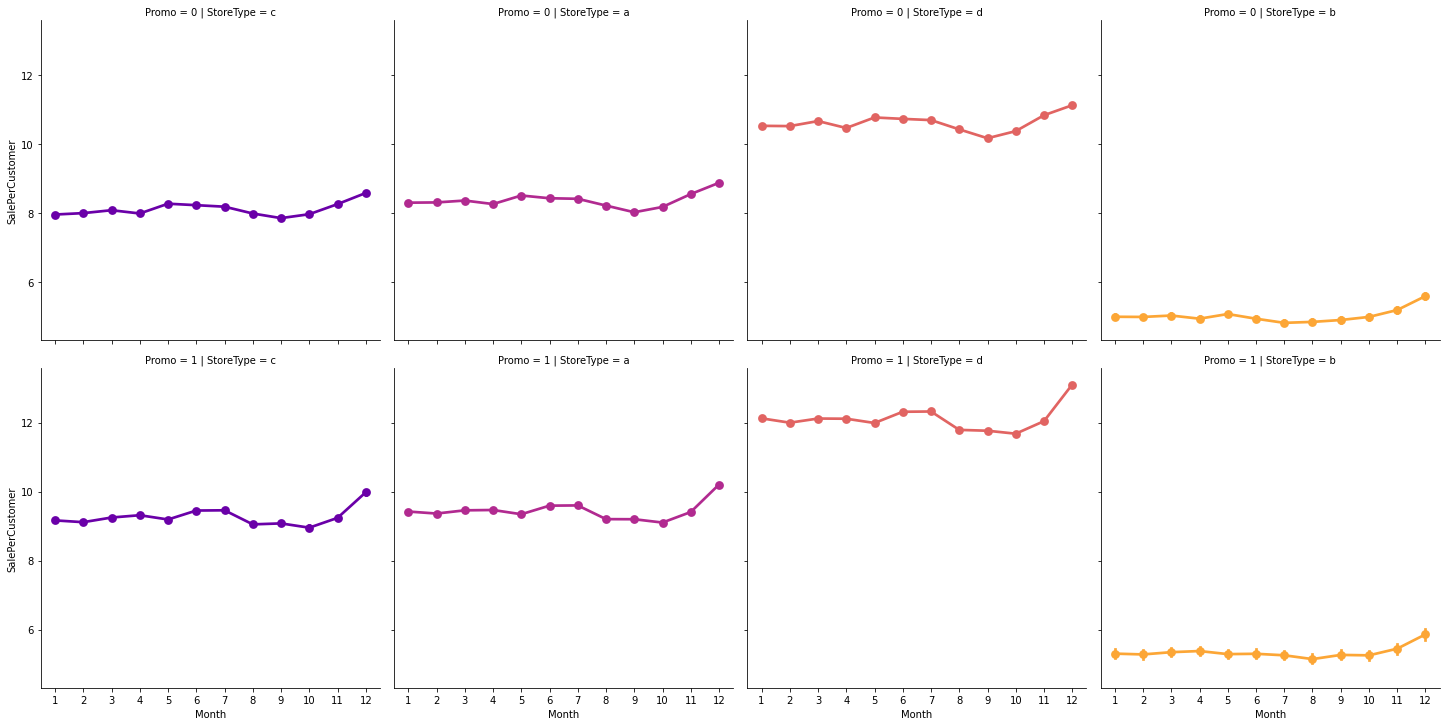

In [32]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

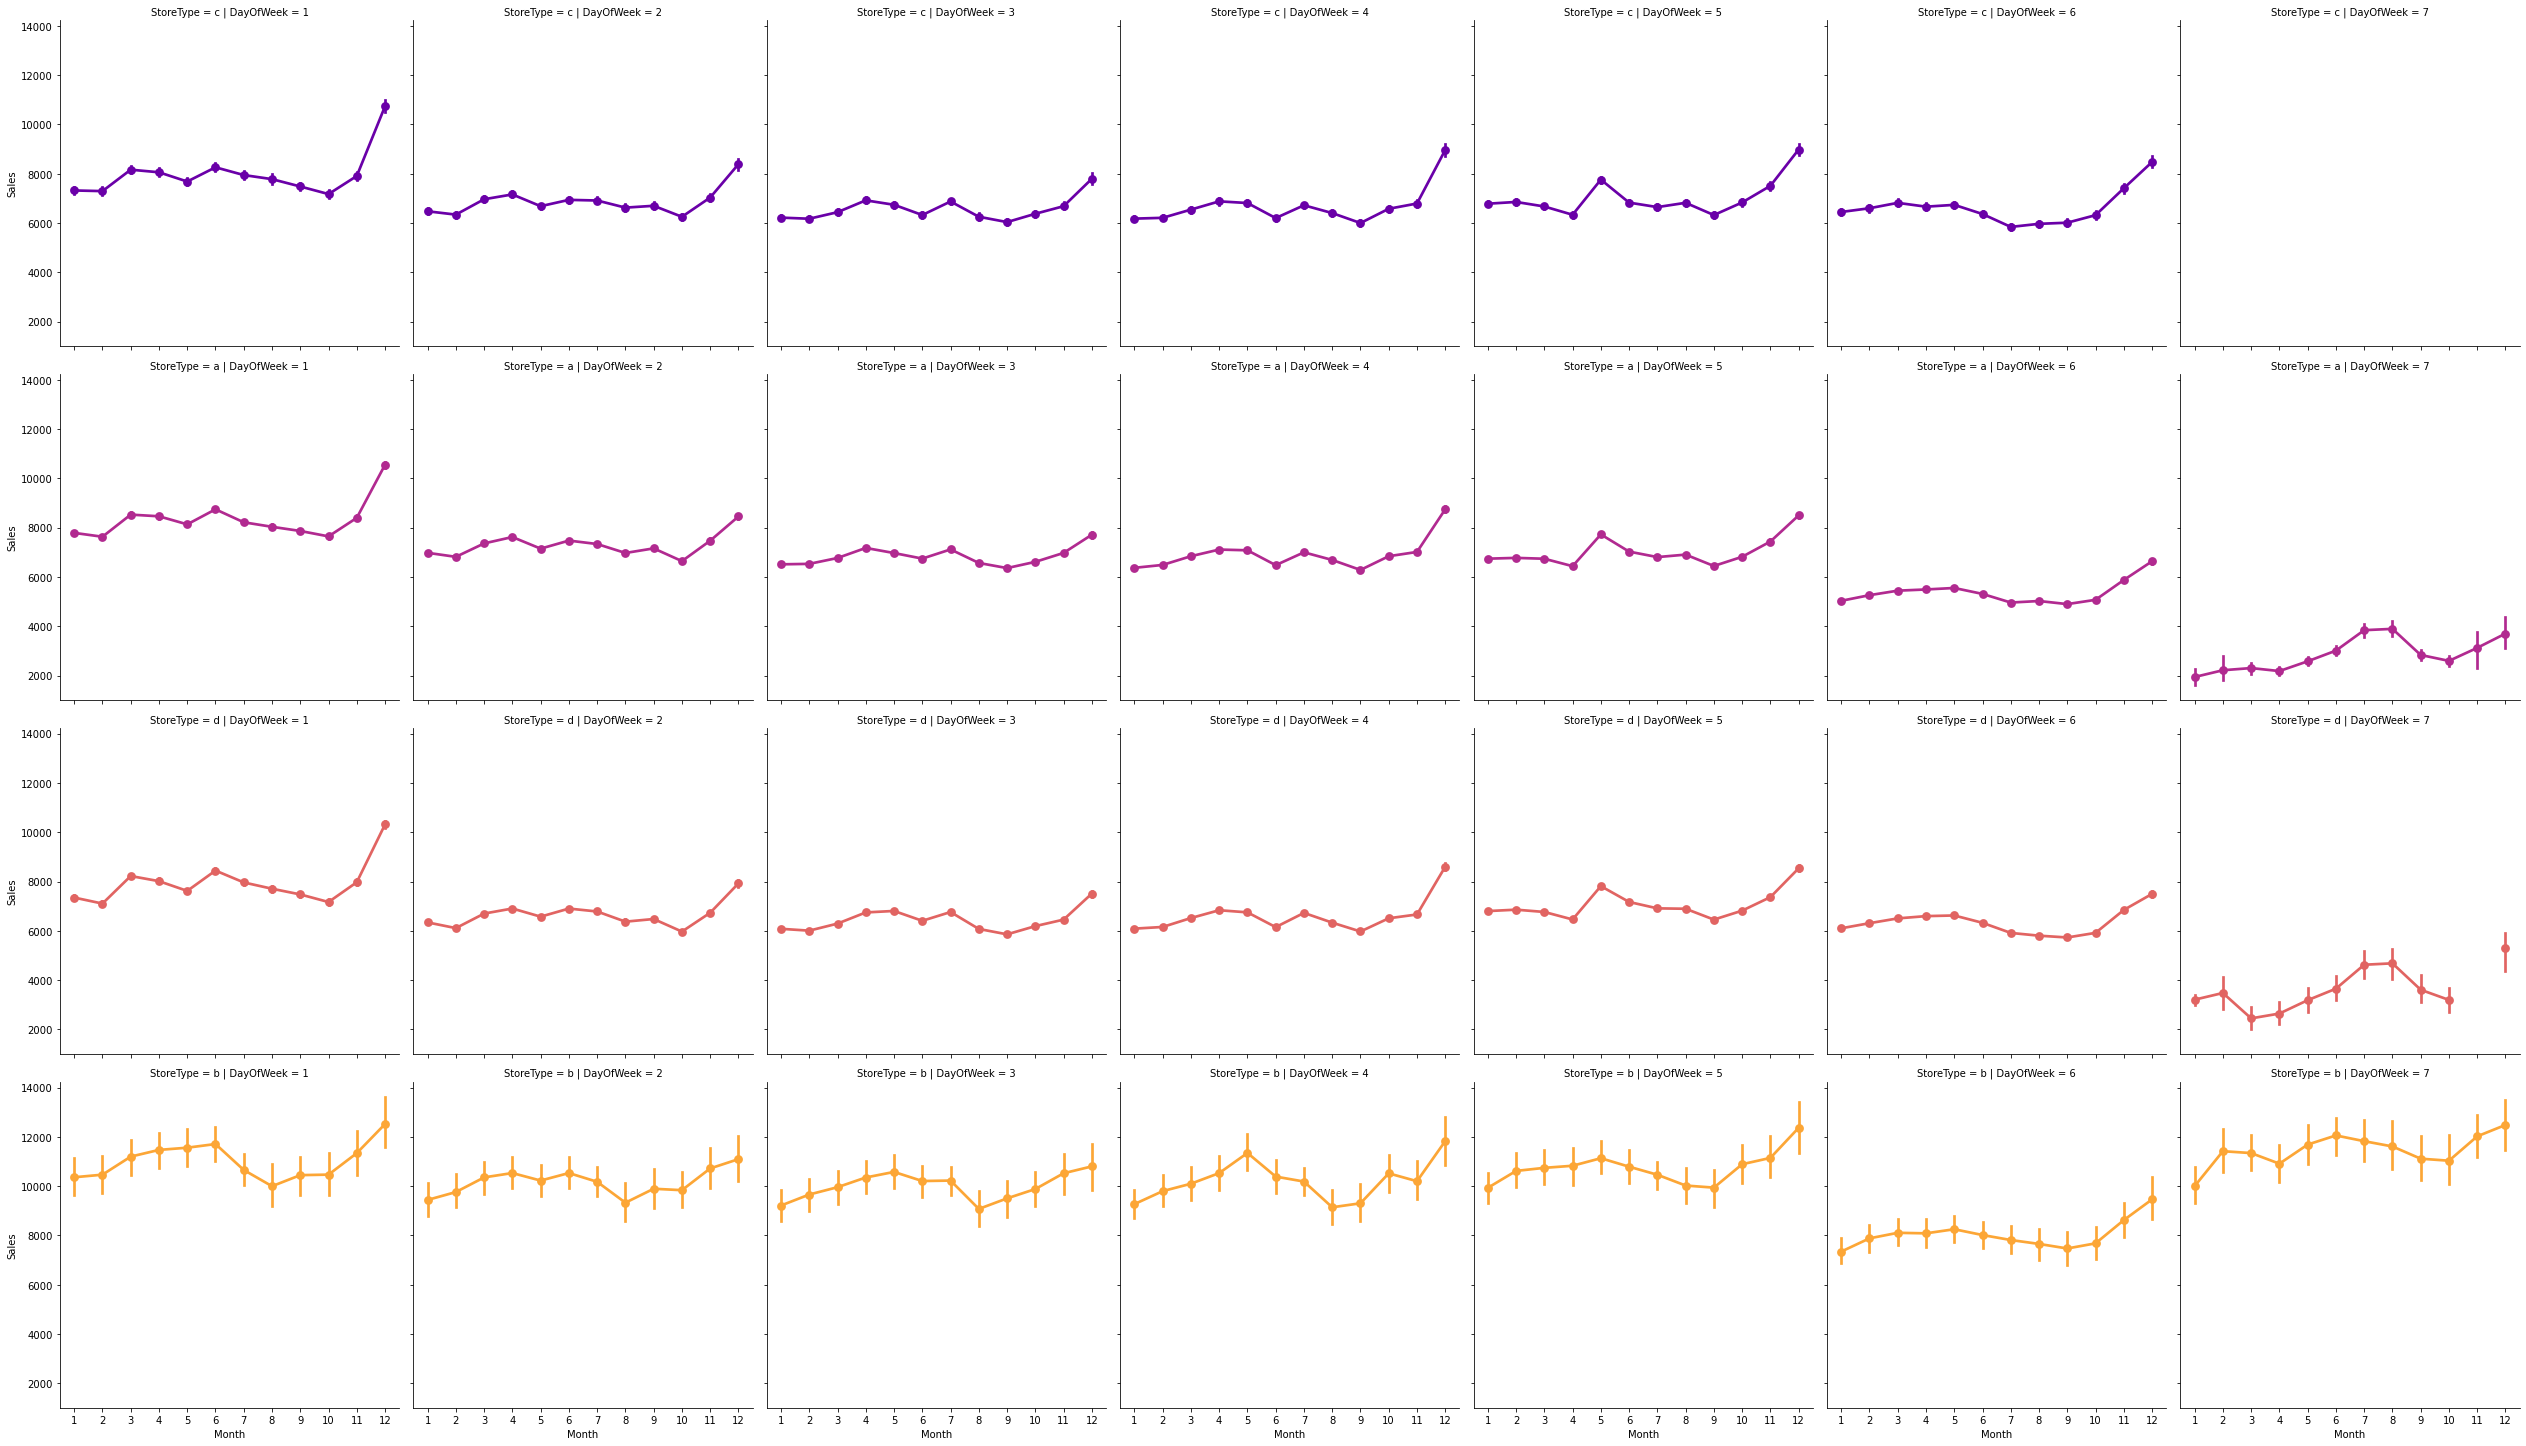

In [33]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType')

#### Observation:
- Clearly any store with promotion attract more customers, leading to higher sales.
- Interestingly, sale escalates toward the end of the year, especially Christmas eve.
- SalePerCustomer is observed at StoreType D with the highest amount, $10 without Promo and 11 with Promo.

In [34]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)  
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# test_store['CompetitionOpen'] = 12 * (test_store['Year'] - test_store['CompetitionOpenSinceYear']) + (test_store['Month'] - test_store['CompetitionOpenSinceMonth'])
# test_store['PromoOpen'] = 12 * (test_store['Year'] - test_store['Promo2SinceYear']) + (test_store['WeekOfYear'] - test_store['Promo2SinceWeek']) / 4.0


# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store[['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


#### Observation:
- StoreType B has the longest running period of promotion.
- It is noticed, StoreType B doesn't generate huge sale amount, but got the largest average sales.

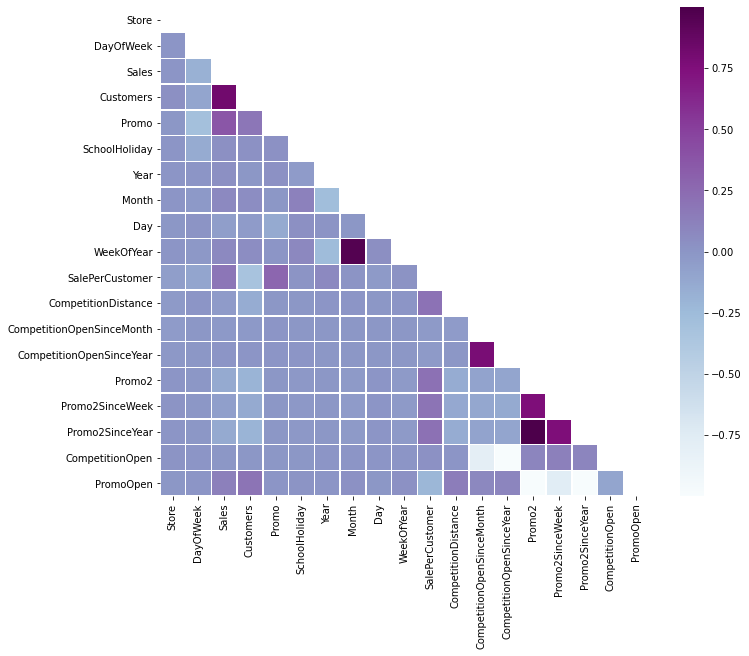

In [35]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

#### Observation:
- There is high relationship between Customers and Sales and Promo, but Promo2

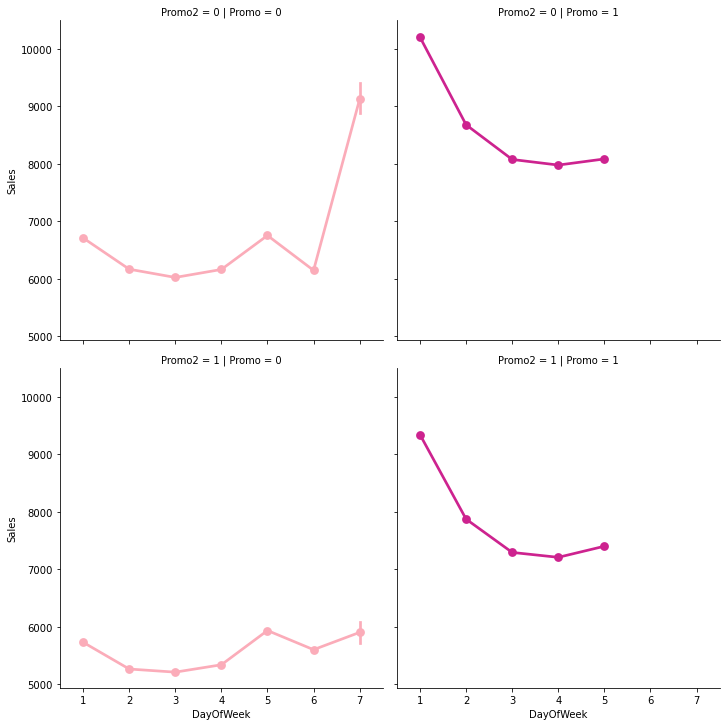

In [36]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo',   # SPECIAL
               palette = 'RdPu') 

#### Observation:
- In the case of no promotion either Promo1 or Promo2, sale peaks on sunday.
- On the contrary, store running Promo1 make the most of sale on monday.
- Promo2 seems irrelevant to overal

<AxesSubplot:xlabel='StateHoliday', ylabel='Sales'>

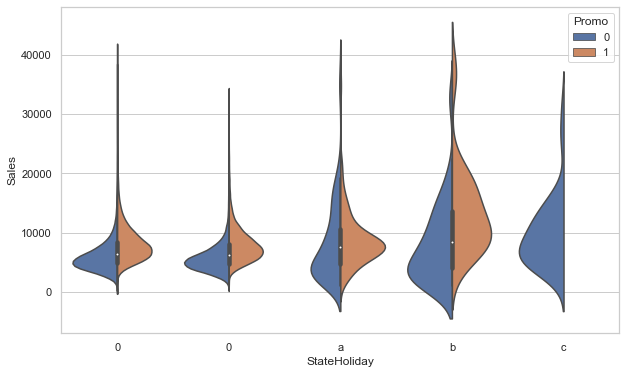

In [37]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.violinplot(x='StateHoliday',y='Sales',hue='Promo',split=True,data=train_store)

<AxesSubplot:xlabel='StoreType', ylabel='count'>

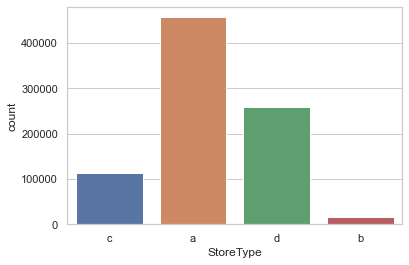

In [38]:
sns.countplot(x='StoreType', data=train_store)

<AxesSubplot:xlabel='StoreType', ylabel='Sales'>

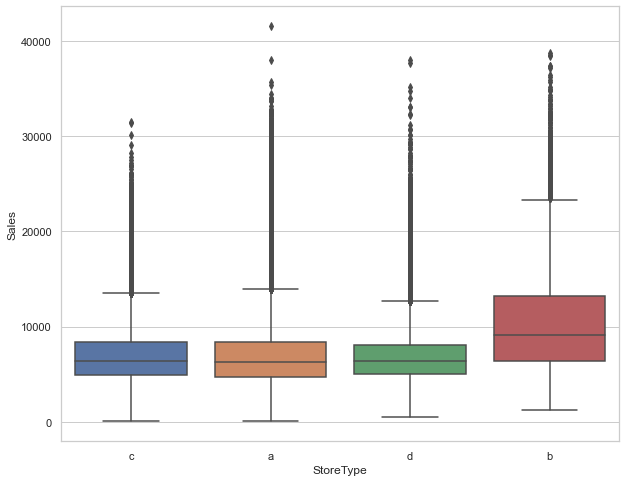

In [39]:
plt.figure(figsize=(10,8))
sns.boxplot(x='StoreType', y='Sales', data=train_store )

<AxesSubplot:xlabel='StoreType', ylabel='SalePerCustomer'>

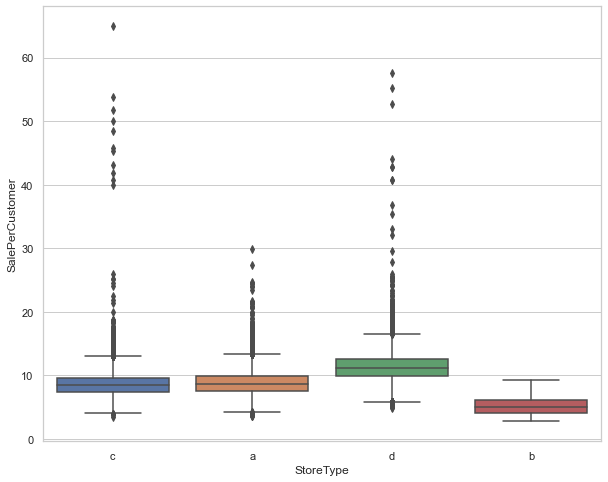

In [40]:
plt.figure(figsize=(10,8))
sns.boxplot(x='StoreType', y='SalePerCustomer', data=train_store)

<AxesSubplot:xlabel='Date', ylabel='Sales'>

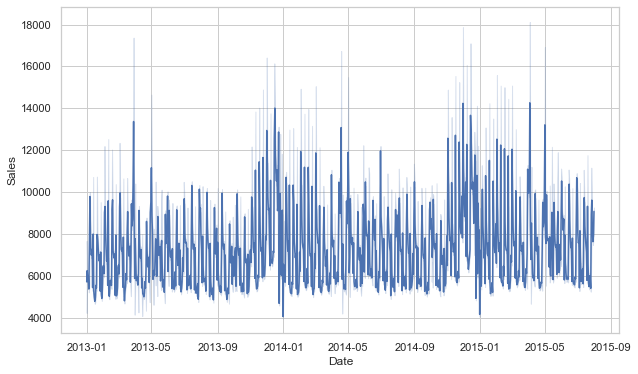

In [41]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.lineplot(x='Date',y='Sales',data=train_store)

In [42]:
train_store['Season']=np.where(train_store['Month'].isin([3,4,5]), "Spring"
                    , np.where(train_store['Month'].isin([6,7,8]), "Summer"
                    , np.where(train_store['Month'].isin([9,10,11]), "Fall"
                    , np.where(train_store['Month'].isin([12,1,2]), "Winter", "None"))))

<AxesSubplot:xlabel='Season', ylabel='Sales'>

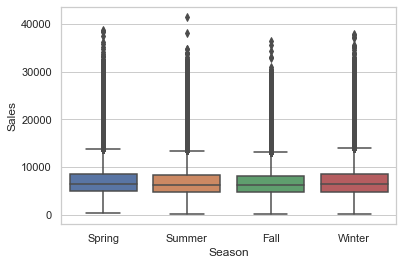

In [43]:
sns.boxplot(x='Season', y='Sales', data=train_store, order=['Spring','Summer','Fall','Winter'])

<AxesSubplot:xlabel='Year', ylabel='Sales'>

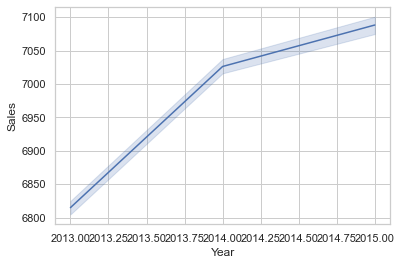

In [44]:
sns.lineplot(data = train_store, x = 'Year', y = "Sales")

<AxesSubplot:xlabel='Month', ylabel='Sales'>

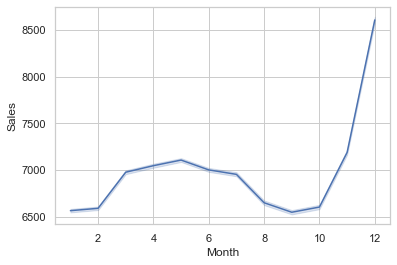

In [45]:
sns.lineplot(data = train_store, x = 'Month', y = "Sales")

<AxesSubplot:xlabel='Day', ylabel='Sales'>

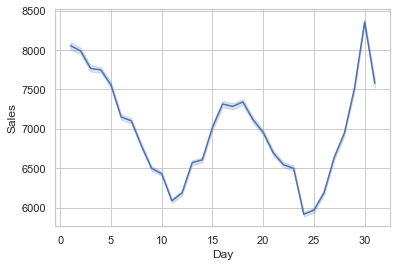

In [46]:
sns.lineplot(data = train_store, x = 'Day', y = "Sales")

<AxesSubplot:xlabel='SalePerCustomer', ylabel='Sales'>

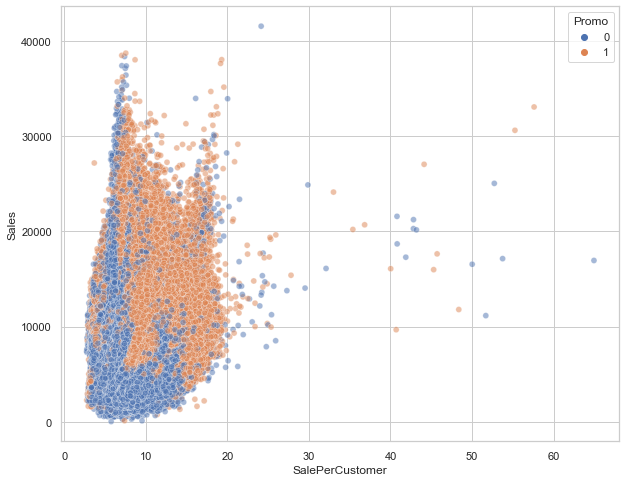

In [47]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='SalePerCustomer', y='Sales',hue= 'Promo', data=train_store, alpha=0.5)

# DATA MANIPULATION

In [48]:
# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

train['StateHoliday'] = train['StateHoliday'].replace(mappings).astype('int64')

test['StateHoliday'] = test['StateHoliday'].replace(mappings).astype('int64')

store['StoreType'] = store['StoreType'].replace(mappings).astype('int64')
store['Assortment'] = store['Assortment'].replace(mappings).astype('int64')
store.drop('PromoInterval', axis = 1, inplace = True)

train_store = pd.merge(train, store, how = 'inner', on = 'Store')
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

### Seasonal_decompose

In [49]:
# Choose 1 store with type a, namely store 2
sales_2 = train[train['Store'] == 2][['Sales', 'Date','StateHoliday','SchoolHoliday']]

In [50]:
sales_2['Date'].sort_index(ascending = False, inplace=True)

In [51]:
a = sales_2.set_index('Date').resample('W').sum()
a

,Sales,StateHoliday,SchoolHoliday
Date,,,
2013-01-06,23704,0,4
2013-01-13,26030,0,5
2013-01-20,29960,0,5
2013-01-27,28006,0,1
2013-02-03,35928,0,0
...,...,...,...
2015-07-05,26228,0,0
2015-07-12,27211,0,0
2015-07-19,23397,0,0


<AxesSubplot:xlabel='Date', ylabel='Sales'>

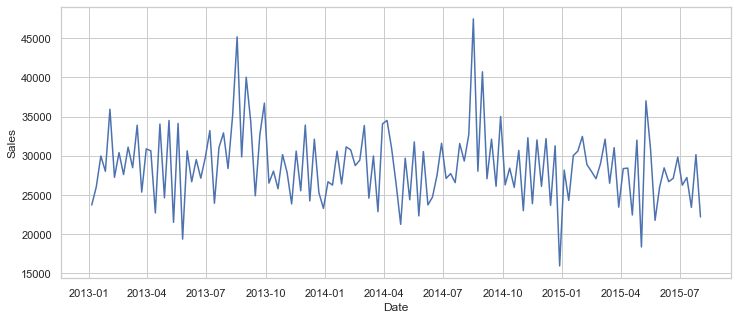

In [52]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=a.index, y=a['Sales'])

#### Observation:
- At the first glance, store 1 show stationary pattern.
- Unfortunately, the trend experience downward.

# REGRESSION MODELS

In [53]:
train_store['CompetitionOpen'] = 12 * (train_store['Year'] - train_store['CompetitionOpenSinceYear']) + (train_store['Month'] - train_store['CompetitionOpenSinceMonth'])
train_store['PromoOpen'] = 12 * (train_store['Year'] - train_store['Promo2SinceYear']) + (train_store['WeekOfYear'] - train_store['Promo2SinceWeek']) / 4.0

test_store['CompetitionOpen'] = 12 * (test_store['Year'] - test_store['CompetitionOpenSinceYear']) + (test_store['Month'] - test_store['CompetitionOpenSinceMonth'])
test_store['PromoOpen'] = 12 * (test_store['Year'] - test_store['Promo2SinceYear']) + (test_store['WeekOfYear'] - test_store['Promo2SinceWeek']) / 4.0

In [54]:
# Sorting dataframe according to datatime, the oldest is on top, the most recent is at the bottom.
train_store['Date'].sort_index(ascending = False, inplace=True)

In [55]:
def rmsle(y_pred, y):
    return np.sqrt(mean_squared_error(y_pred, y))

def model_check (estimators):
    model_table = pd.DataFrame()
    row_index = 0
    
    for est in estimators:
        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        
        est.fit(x_train, y_train)
        y_pred = est.predict(x_test)
        model_table.loc[row_index, 'Test Error'] = rmsle(y_pred, y_test)
        
        row_index += 1
        
        model_table.sort_values(by=['Test Error'],
                            ascending=True,
                            inplace=True)
    return model_table

In [56]:
# MODELS
lr = LinearRegression()
ls = Lasso()
GBoost = GradientBoostingRegressor(random_state = 0)
XGBoost = XGBRegressor(random_state = 0, n_job=-1)
LGBM = LGBMRegressor(random_state = 0, n_job=-1)

In [57]:
# Training dataset is separated into train_a and test_a.
# traing_a train data from 2013 till 2015-06-30, while test_a contain  data from 2015-07-01 till 2015-07-31.

train_a = train_store.set_index('Date').loc[:'2015-06-30']
test_a = train_store.set_index('Date').loc['2015-07-01':]

x_train = train_a.drop(['Sales', 'Customers'], axis=1)
y_train = train_a['Sales']
x_test = test_a.drop(['Sales', 'Customers'], axis=1)
y_test = test_a['Sales']

In [58]:
estimators = [lr, ls, GBoost, XGBoost, LGBM]
model_check(estimators)

[10:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_job" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] Unknown parameter: n_job


,Model Name,Test Error
3,XGBRegressor,1079.952905
4,LGBMRegressor,1616.072804
2,GradientBoostingRegressor,2272.147321
0,LinearRegression,2672.310857
1,Lasso,2672.421082


In [59]:
# This part is different from the above. This particularly examinze the prediction power on store 2 only.

train_a = train_store[train_store['Store']==2].set_index('Date').loc[:'2015-06-30']
test_a = train_store[train_store['Store']==2].set_index('Date').loc['2015-07-01':]

x_train = train_a.drop(['Sales', 'Customers','SalePerCustomer'], axis=1)
y_train = train_a['Sales']
x_test = test_a.drop(['Sales', 'Customers', 'SalePerCustomer'], axis=1)
y_test = test_a['Sales']

In [60]:
XGBoost = XGBRegressor(random_state = 0, n_job=-1).fit(x_train, y_train)
y_pred = XGBoost.predict(x_test)
LGBM = LGBMRegressor(random_state = 0, n_job=-1).fit(x_train, y_train)
y_pred = LGBM.predict(x_test)

[10:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_job" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] Unknown parameter: n_job


#### Observation:
- Seeing both feature importance of XGBoost and LightGBM show similar patterns.
- Day, DayOfWeek, WeekOfYear, PromoOpen, Promo primarily account for sale amount

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

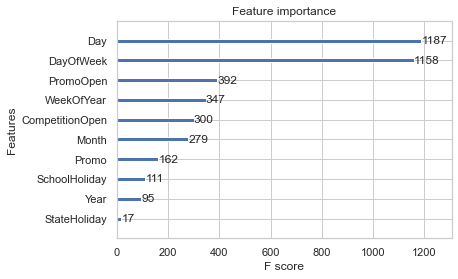

In [61]:
xgb.plot_importance(XGBoost)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

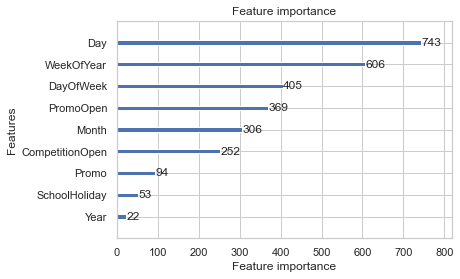

In [62]:
lightgbm.plot_importance(LGBM)